# Multivariate Time Series Forecasting with Keras and TensorFlow


continued from Notebook 02


## 03. Dilated Causal CNN Model Implementation



### Contents

* read data and check -- plot random intervals 
* split data
* scale data
* Data Generator helper function
* validation set -- till here, code is the same as notebook 02
* Create the Dilated Causal CNN Model
* Standard loss function for this model -- MSE
* Compile the model
* Callback functions -- optimize LR, record checkpoints -- not implemented
* Train the Recurrent Neural Network
* Load checkpoint, in case of early stop -- optional 
* Performance on Test set
* Generate predictions


Technical Note: It's recommended to run this Notebook 03 in Colab or locally only w/ CUDA GPU.

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# optional -- to read directly from drive
# for local load -- do directly pd.read_pickle with the respective path
#from google.colab import drive
#drive.mount("/content/gdrive")


#from google.colab import files
#files.download('cp.ckpt')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#!ls {"/home/o/Documents"} # for the dl1
#!ls {"/Users/oggy/Documents/dl101"} # for the MacBook Pro

ls: cannot access '/Users/oggy/Documents/dl101': No such file or directory


In [3]:
#test2 = pd.read_pickle("/home/o/Documents/weather_VAR_SOF")
#test2 = pd.read_pickle("/Users/oggy/Documents/dl101/weather_VAR_SOF")
#test2 = pd.read_pickle("/content/gdrive/My Drive/weather_VAR_SOF")

test2 = pd.read_pickle("weather_VAR_SOF1")


In [4]:
test2.head()

Varna                Sofia              Various     
                      Temp, C     SLP, hPa Temp, C     SLP, hPa     Day Hour
Date_Time                                                                   
1973-01-01 00:00:00 -2.780000  1046.300000   -3.89  1047.100000       1    0
1973-01-01 01:00:00 -3.520000  1046.266667   -3.89  1047.133333       1    1
1973-01-01 02:00:00 -4.260000  1046.233333   -3.89  1047.166667       1    2
1973-01-01 03:00:00 -5.000000  1046.200000   -3.89  1047.200000       1    3
1973-01-01 04:00:00 -3.981667  1046.566667   -5.00  1047.466667       1    4

<AxesSubplot:xlabel='Date_Time'>

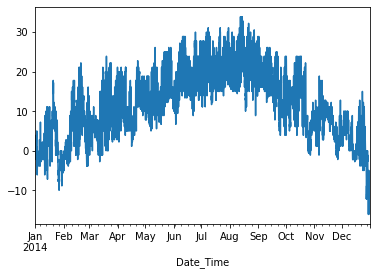

In [5]:
test2["Sofia"]["Temp, C"]['2014-01':'2014-12'].plot()

<AxesSubplot:xlabel='Date_Time'>

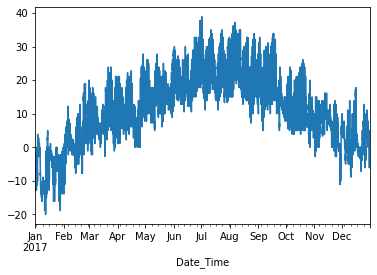

In [6]:
test2["Sofia"]["Temp, C"]['2017-01':'2017-12'].plot()

<AxesSubplot:xlabel='Date_Time'>

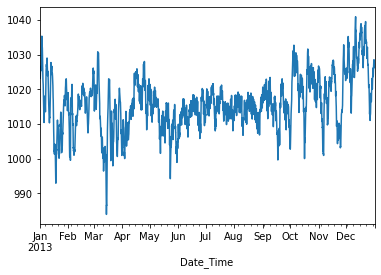

In [7]:
test2["Sofia"]["SLP, hPa"]['2013-01':'2013-12'].plot()

<AxesSubplot:xlabel='Date_Time'>

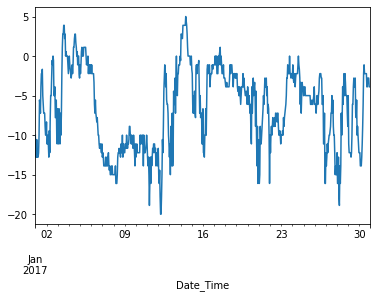

In [8]:
test2["Sofia"]["Temp, C"]['2017-01-01':'2017-01-30'].plot()

In [9]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 401784 entries, 1973-01-01 00:00:00 to 2018-11-01 23:00:00
Freq: 60T
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   (Varna, Temp, C)   401784 non-null  float64
 1   (Varna, SLP, hPa)  401784 non-null  float64
 2   (Sofia, Temp, C)   401784 non-null  float64
 3   (Sofia, SLP, hPa)  401784 non-null  float64
 4   (Various, Day)     401784 non-null  int64  
 5   (Various, Hour)    401784 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 29.5 MB


In [10]:
target_city = "Sofia"

In [11]:
target_names = ["Temp, C"]
# can do more than one

In [12]:
shift_days = 3
shift_steps = shift_days * 24  # Number of hours.

In [13]:
df_targets = test2[target_city][target_names].shift(-shift_steps)

In [14]:
test2.head(72)

Varna                Sofia              Various     
                      Temp, C     SLP, hPa Temp, C     SLP, hPa     Day Hour
Date_Time                                                                   
1973-01-01 00:00:00 -2.780000  1046.300000   -3.89  1047.100000       1    0
1973-01-01 01:00:00 -3.520000  1046.266667   -3.89  1047.133333       1    1
1973-01-01 02:00:00 -4.260000  1046.233333   -3.89  1047.166667       1    2
1973-01-01 03:00:00 -5.000000  1046.200000   -3.89  1047.200000       1    3
1973-01-01 04:00:00 -3.981667  1046.566667   -5.00  1047.466667       1    4
...                       ...          ...     ...          ...     ...  ...
1973-01-03 19:00:00  1.850000  1027.933333    0.00  1028.433333       3   19
1973-01-03 20:00:00  1.480000  1027.866667    0.00  1028.366667       3   20
1973-01-03 21:00:00  1.110000  1027.800000    0.00  1028.300000       3   21
1973-01-03 22:00:00  1.110000  1027.733333    0.00  1028.100000       3   22
1973-01-03 23:00:00  1.110000  1027.666667    0.00  1027.900000       3   23

[72 rows x 6 columns]

In [15]:
df_targets.tail()

,"Temp, C"
Date_Time,
2018-11-01 19:00:00,NaN
2018-11-01 20:00:00,NaN
2018-11-01 21:00:00,NaN
2018-11-01 22:00:00,NaN
2018-11-01 23:00:00,NaN


Check is the shift is OK -- NaN is expected -- the future is unknown.

In [ ]:
#NumPy Arrays

In [16]:
x_data = test2.values[0:-shift_steps]

In [17]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (401712, 6)


In [18]:
y_data = df_targets.values[:-shift_steps]

In [19]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (401712, 1)


In [20]:
num_data = len(x_data)
print(num_data)

train_split = 0.9

#This is the number of observations in the training-set:

num_train = int(train_split * num_data)
print(num_train)

#This is the number of observations in the test-set:

num_test = num_data - num_train
print(num_test)

401712
361540
40172


In [21]:
#This is the number of input-signals:

num_x_signals = x_data.shape[1]
print(num_x_signals)

#This is the number of output-signals:

num_y_signals = y_data.shape[1]
print(num_y_signals)

6
1


In [22]:
#These are the input-signals for the training- and test-sets:

x_train = x_data[0:num_train]
x_test = x_data[num_train:]
print(len(x_train) + len(x_test))

#These are the output-signals for the training- and test-sets:

y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print(len(y_train) + len(y_test))

401712
401712


### Scale Data


The data-set contains a wide range of values:

In [23]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -25.0
Max: 1070.2


In [24]:
#We first create a scaler-object for the input-signals.


x_scaler = MinMaxScaler()

#We then detect the range of values from the training-data and scale the training-data.

x_train_scaled = x_scaler.fit_transform(x_train)

#Apart from a small rounding-error, the data has been scaled to be between 0 and 1.
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))


Min: 0.0
Max: 1.0


In [25]:
#We use the same scaler-object for the input-signals in the test-set.

x_test_scaled = x_scaler.transform(x_test)
x_test_scaled = x_scaler.transform(x_test)


#The target-data comes from the same data-set as the input-signals, because it is the weather-data for one of the cities that is merely time-shifted. But the target-data could be from a different source with different value-ranges, so we create a separate scaler-object for the target-data.

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)


## Data Generator

The data-set has now been prepared as 2-dimensional numpy arrays. The training-data has over 360k observations, consisting of 6 input signals and 1 output signal.

These are the array-shapes of the input and output data:

In [26]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(361540, 6)
(361540, 1)


Instead of training the Recurrent Neural Network on the complete sequences of almost 300k observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [27]:
# batch generator function from [2]
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [47]:
# bigger batch for this algorithm as it works faster
batch_size = 256 #128 2048 #1024 #
#We will use a sequence-length of 1344, which means that each random sequence 
#contains observations for 8 weeks. One time-step corresponds to one hour, so 
#24 x 7 time-steps corresponds to a week, and 24 x 7 x 8 corresponds to 8 weeks.

sequence_length = 24 * 7 * 4 # 4 weeks
# 8 weeks

print(sequence_length)

672


In [48]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [49]:
x_batch, y_batch = next(generator)

In [50]:
print(x_batch.shape)
print(y_batch.shape)

(256, 672, 6)
(256, 672, 1)


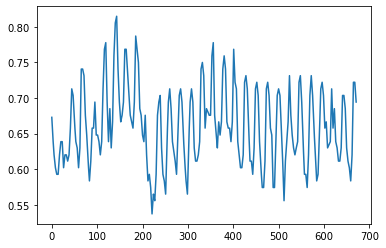

In [51]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 6 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

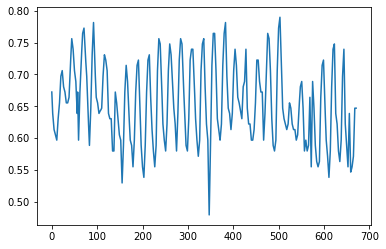

In [52]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training-set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each epoch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [53]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## Create the Model: Dilated Causal Convolution NN

Data is now ready to attempt the DCCNN Model. Keras API is used from TF, unlike [3]

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, Dense, GRU, Embedding
# from tensorflow.keras.optimizers import RMSprop
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [35]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from tensorflow.keras.optimizers import Adam

In [36]:
import tensorflow as tf
import os

In [37]:
tf.__version__

'2.5.0'

In [38]:
# from [5]
# reshape from [samples, timesteps] into [samples, timesteps, features]
#X = X.reshape((X.shape[0], X.shape[1], 1))

In [54]:
# Keras Sequential definition -- var model2

#num_x_signals=6
#p = "valid" 
p='causal' # this only works in 1.12+ -- December 2018+

model2 = Sequential([
    #Conv1D(filters=n_filters, kernel_size=filter_width, padding='causal', dilation_rate=1),
    # padding= One of "valid" or "same"
    #Input(shape=(None, 1)), 
    #Input(shape=(None, num_x_signals)), This is not for Sequential
    Conv1D(filters=32, input_shape=( None, num_x_signals ), 
           kernel_size=2, padding='causal', dilation_rate=1),
    Conv1D(filters=32, kernel_size=2, padding=p, dilation_rate=2),
    Conv1D(filters=32, kernel_size=2, padding=p, dilation_rate=4),
    Conv1D(filters=32, kernel_size=2, padding=p, dilation_rate=8),
    Conv1D(filters=32, kernel_size=2, padding=p, dilation_rate=16),
    Conv1D(filters=32, kernel_size=2, padding=p, dilation_rate=32),
    Conv1D(filters=32, kernel_size=2, padding=p, dilation_rate=64),
    Conv1D(filters=32, kernel_size=2, padding=p, dilation_rate=128),
    Dense(128, activation=tf.nn.relu), #model.add(Dense(num_y_signals, activation="tanh"))   #'sigmoid'))
    Dropout(.2),
    Dense(1, activation="tanh") 
    #Dense(1),
    
])

#optimizer = tf.train.RMSPropOptimizer(0.001)

model2.compile(Adam(), loss='mean_absolute_error')



In [55]:
# Keras model definition using the Functional API -- var name "model"

# in [3] they use functional definition of the NN
# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, num_x_signals))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last 14 time steps as the training target
#def slice(x, seq_length):
#    return x[:,-seq_length:,:]
# I don't need this in here, it [3] they do the shift here, w/TF Lambda 

#pred_seq_train = Lambda(slice, arguments={'seq_length':sequence_length})(x)

#model = Model(history_seq, pred_seq_train)
model = Model(history_seq, x)

# help on Keras functional API: https://www.tensorflow.org/guide/keras#functional_api
#model = tf.keras.Model(inputs=inputs, outputs=predictions

### Compile model

In [92]:
model.compile(Adam(), loss='mean_absolute_error', metrics=["mse", "mape"])

In [ ]:
#model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [84]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, None, 32)          416       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_20 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, None, 32)         

In [93]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 6)]         0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, None, 32)          416       
_________________________________________________________________
conv1d_25 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_26 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_27 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_28 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_29 (Conv1D)           (None, None, 32)          2080

In [59]:
#tf.test.gpu_device_name()

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Train the Recurrent Neural Network

We can now train the neural network.

Note that a single "epoch" does not correspond to a single processing of the training-set, because of how the batch-generator randomly selects sub-sequences from the training-set. Instead we have selected `steps_per_epoch` so that one "epoch" is processed in a few minutes.

With these settings, each "epoch" took about 80 sec to process on Colab and 100sec on a 4x GTX 1060 / 6GB. Total of 11min 38s and 13.27 respectively.

Also note that the loss sometimes becomes `NaN` (not-a-number). This is often resolved by restarting and running the Notebook again. But it may also be caused by your neural network architecture, learning-rate, batch-size, sequence-length, etc. in which case you may have to modify those settings.

In [60]:
%%time
history2 = model2.fit(x= generator,
                    epochs= 10,
                    steps_per_epoch=100,
                    validation_data=validation_data)
                    #, callbacks=callbacks)

Epoch 1/10
100/100 [==============================] - 21s 184ms/step - loss: 0.0876 - val_loss: 0.0506
Epoch 2/10
100/100 [==============================] - 18s 178ms/step - loss: 0.0575 - val_loss: 0.0490
Epoch 3/10
100/100 [==============================] - 18s 178ms/step - loss: 0.0556 - val_loss: 0.0483
Epoch 4/10
100/100 [==============================] - 18s 178ms/step - loss: 0.0546 - val_loss: 0.0484
Epoch 5/10
100/100 [==============================] - 18s 177ms/step - loss: 0.0542 - val_loss: 0.0482
Epoch 6/10
100/100 [==============================] - 18s 178ms/step - loss: 0.0536 - val_loss: 0.0480
Epoch 7/10
100/100 [==============================] - 18s 178ms/step - loss: 0.0533 - val_loss: 0.0490
Epoch 8/10
100/100 [==============================] - 18s 178ms/step - loss: 0.0528 - val_loss: 0.0479
Epoch 9/10
100/100 [==============================] - 18s 178ms/step - loss: 0.0523 - val_loss: 0.0478
Epoch 10/10
100/100 [==============================] - 18s 179ms/step - l

In [94]:
%%time
history = model.fit(x= generator,
                    epochs= 10,
                    steps_per_epoch=100,
                    validation_data=validation_data)
#                    callbacks=callbacks)
# no callbacks here

Epoch 1/10
100/100 [==============================] - 20s 188ms/step - loss: 0.0510 - mse: 0.0043 - mape: 1216.2904 - val_loss: 0.0466 - val_mse: 0.0036 - val_mape: 9.5407
Epoch 2/10
100/100 [==============================] - 18s 183ms/step - loss: 0.0481 - mse: 0.0039 - mape: 1044.8020 - val_loss: 0.0456 - val_mse: 0.0035 - val_mape: 9.4209
Epoch 3/10
100/100 [==============================] - 18s 182ms/step - loss: 0.0481 - mse: 0.0039 - mape: 898.0713 - val_loss: 0.0460 - val_mse: 0.0036 - val_mape: 9.4682
Epoch 4/10
100/100 [==============================] - 18s 182ms/step - loss: 0.0480 - mse: 0.0039 - mape: 857.8203 - val_loss: 0.0468 - val_mse: 0.0036 - val_mape: 9.6047
Epoch 5/10
100/100 [==============================] - 18s 182ms/step - loss: 0.0478 - mse: 0.0038 - mape: 1019.8245 - val_loss: 0.0461 - val_mse: 0.0036 - val_mape: 9.5083
Epoch 6/10
100/100 [==============================] - 18s 182ms/step - loss: 0.0476 - mse: 0.0038 - mape: 1104.9126 - val_loss: 0.0463 - val_m

In [95]:
# Save the weights
#model.save_weights('./checkpoints/my_checkpoint')

# Restore the weights
#model = create_model()
#model.load_weights('./checkpoints/my_checkpoint')


model.save('DCCNN_model.h5')

In [64]:
model2.save('DCCNN_model2.h5')

In [ ]:
# reload optimal if needed 
# try:
#     model.load_weights(path_checkpoint)
# except Exception as error:
#     print("Error trying to load checkpoint.")
#     print(error)

In [96]:
file_p = "./test2"
tf.keras.models.save_model(
    model,
    filepath=file_p,
    overwrite=True,
    include_optimizer=True
)

INFO:tensorflow:Assets written to: ./test2\assets


### Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [66]:
result = model2.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 32ms/step - loss: 0.0479


In [67]:
print("loss (test-set):", result)

loss (test-set): 0.047856785356998444


0.0465210

In [97]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 42ms/step - loss: 0.0461 - mse: 0.0036 - mape: 9.4761


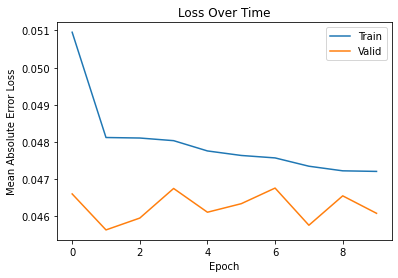

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss') #?!
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

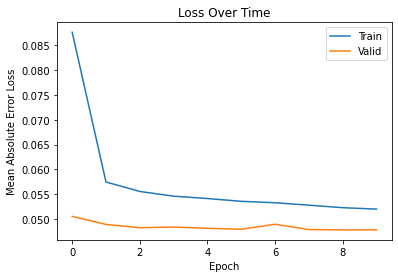

In [70]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss') #?!
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

### Generate Predictions

This helper-function plots the predicted and true output-signals.

In [71]:
warmup_steps=50

In [72]:
# true vs predicted plot function borrowed from [2]
# also scales back to the original (temperature)
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

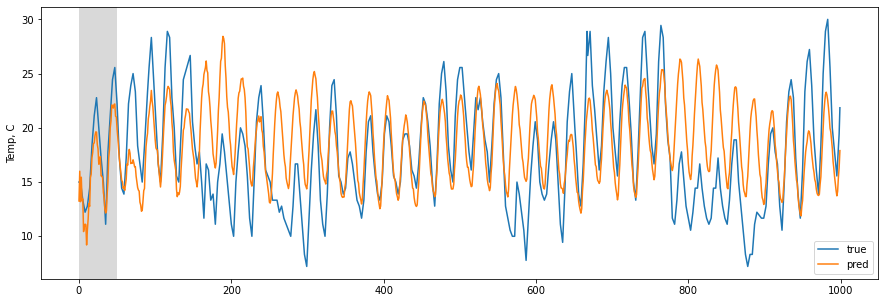

In [73]:
plot_comparison(start_idx=100000, length=1000, train=True)

Example above is from the training data

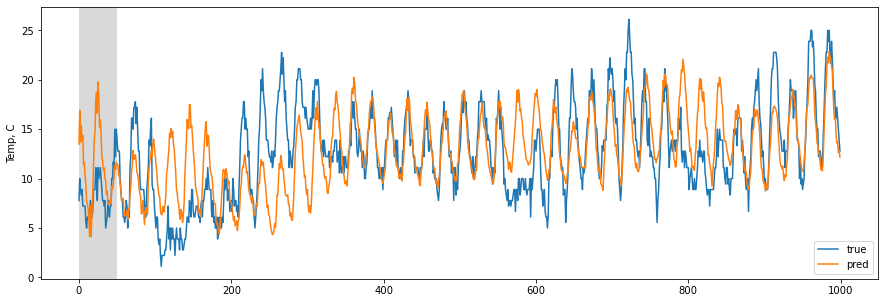

In [74]:
plot_comparison(start_idx=200, length=1000, train=False)

Example above is from the Test set

In [99]:
model.metrics_names

['loss', 'mse', 'mape']

## Future rework / Conclusions

While there is no real domain value for the meteorology, the GRU and Dilated Causal CNN models captured realy well the daily oscilations of the series.  The implementations helped me grasp  the Multivariate series prediction and the Keras functional API vs Sequential model definition.

The Dilated Causal CNN Model Implementation has better performance in prediction / evaluation.  Training times are similar to the GRU.

The Dilated Causal CNN Model is probaly transfers less data than the GRU model -- the performance in Colab and the local multi-GPU was similar.  Colab was even a bit faster.  While GRU training was significantly faster at the local machine, almost 2x.

> The combination of causal filters with dilated convolutions allow their receptive fields to grow exponentially with depth, which is important to model the long-range temporal dependencies [4]

The padding='causal' in Keras Sequential is very new (Dec 2018) and only worked out after updating to the very latest version of Tensorflow 1.12.

Some future improvement needed:

* Optimize the parameters for the Dilated Causal CNN Model


* Implement identical MSE metric and callbacks for both models


* Rework the batch generator and plot functions -- so they can work on multiple models; no global variables etc.



* Resample and work with two separate sets -- e.g. 0600, morning temperature and pressure and others and 1800, afternoon.  See figure below from real meteo forecast:
Typical "Hi/Lo" prediction by real meteorologists:

![](https://drive.google.com/uc?export=view&id=1pVpm3At3z-4ItKqFATxCKuyhZY4LuEmd)


* Implement Walk-forward validation split (as in [3]) as oposed to just Side-by-side split


* Try use_multiprocessing=True, workers=4) in .fit_generator for both models.  I'm not sure .fit_generator is parallel by default.

* Try implement Neural Ordinary Differential Equations, [6]





## References



1. Magnus Erik Hvass Pedersen, [TensorFlow-Tutorials](http://www.hvass-labs.org/)
/ [GitHub repo](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

2. Ognian Dantchev, Multivariate Time Series Forecasting with Keras and TensorFlow, [GitHub repo](https://github.com/ogniandantchev/dilated_causal_cnn_time_series)


